### Data Loading and Exploration ###

In [1]:
import os
os.environ["os.environ['CUDA_LAUNCH_BLOCKING"] = "1"

Below, the data is loaded from the folders Benign and Malignant into the lists images, and labels.

In [2]:
from PIL import Image
import glob

data_root = # Folder containing all data
categories = ['Benign', 'Malignant']

def load_images(folder):
    images, labels = [], []
    for category in categories:
        image_paths = glob.glob(os.path.join(folder, category, '*.jpg'))
        for image_path in image_paths:
            image = Image.open(image_path).convert('RGB')
            images.append(image)
            label = 0.0 if category=='Benign' else 1.0
            labels.append(label)
    return images, labels


all_images, all_labels = load_images(data_root)

To make sure the network doesn't overfit to the training data, a validation dataset is created, separate from the test dataset to be used for early stopping. The data is split between training-validation-testing, 60%-20%-20% and stratified on labels to ensure that the balance between the two classes doesn't change between each of the three datasets. 

In [3]:
from sklearn.model_selection import train_test_split

dev_images, test_images, dev_labels, test_labels = train_test_split(
all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels, shuffle=True)

train_images, val_images, train_labels, val_labels = train_test_split(
dev_images, dev_labels, test_size=0.25, random_state=42, stratify=dev_labels, shuffle=True)

To better understand the data, let's consider a few samples from each class

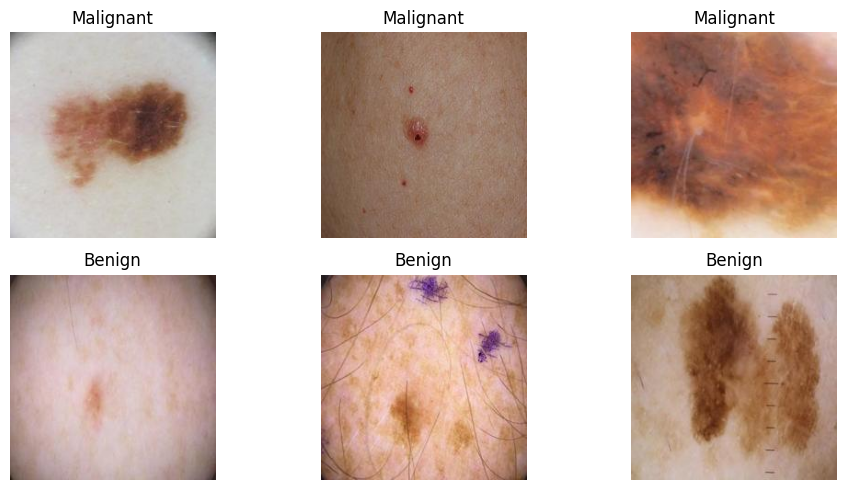

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


indices_malignant = [i for i, lbl in enumerate(train_labels) if lbl == 1]
indices_benign = [i for i, lbl in enumerate(train_labels) if lbl == 0]


selected_malignant = np.random.choice(indices_malignant, 3, replace=False)
selected_benign = np.random.choice(indices_benign, 3, replace=False)


images_malignant = [train_images[i] for i in selected_malignant]
images_benign = [train_images[i] for i in selected_benign]

selected_images = images_malignant + images_benign


plt.figure(figsize=(10, 5))

for index, img in enumerate(selected_images):
    plt.subplot(2, 3, index + 1) 
    plt.imshow(img)
    plt.title('Malignant' if index < 3 else 'Benign') 
    plt.axis('off')  

plt.tight_layout()
plt.show()


It's important to note that the images are at different illumination, angles, and scales. This makes the diagnosis task more challenging since the classifier will need to be robust to changes in these factors. To address this issue, data augmentation is used below to transform the training data

### Data Augmentation ###

Two different image transforms are created, one for the training data, and antoher one for the validation and test data. These are key to learning a robust classifier since the images in the dataset are from different angles and with different illumination. The test_transform transforms the image to a PyTorch Tensor and normalizes values. This transform is applied to the test and validation data to make sure the training and testing data are standardized in the same way. The train_transform randomly flips and rotates the image before transforming it into a PyTorch Tensor and normalizing it.

In [6]:
import random

class RandomCenterCropResize(object):
    def __init__(self, crop_size, resize_size, probability=0.5):
        super().__init__()
        self.crop_size = crop_size
        self.resize_size = resize_size
        self.probability = probability

    def __call__(self, img):
        if random.random() < self.probability:
            center_x, center_y = img.size[0] // 2, img.size[1] // 2
            half_crop_size = self.crop_size // 2
            left = max(center_x - half_crop_size, 0)
            upper = max(center_y - half_crop_size, 0)
            right = min(center_x + half_crop_size, img.size[0])
            lower = min(center_y + half_crop_size, img.size[1])

            img = img.crop((left, upper, right, lower))
            img = img.resize((self.resize_size, self.resize_size), Image.BILINEAR)
        return img

In [7]:
from torchvision import transforms, datasets


train_transform = transforms.Compose([
    RandomCenterCropResize(crop_size=112, resize_size=224, probability=0.5),
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Below, the transformations are applied to all the images in the datasets and the results are saved as a .pth file for later use

In [8]:
import torch

save_folder = # Folder to save the PyTorch Files

def build_dataset(data, labels, transform, data_file, label_file):
    images = []
    for i in range(len(data)):
        img = transform(data[i])
        images.append(img)
    torch_images = torch.stack(images)
    torch_labels = torch.tensor(labels)
    torch.save(torch_images, os.path.join(save_folder, data_file))
    torch.save(torch_labels, os.path.join(save_folder, label_file))

build_dataset(train_images, train_labels, train_transform, 'train_data.pth', 'train_labels.pth')
build_dataset(val_images, val_labels, test_transform, 'val_data.pth', 'val_labels.pth')
build_dataset(test_images, test_labels, test_transform, 'test_data.pth', 'test_labels.pth')

The PyTorch files are loaded, and used to create the training, validation, and test DataLoaders with a Batch size of 128. This large batch size ensures that the updates are consistent and always useful. To ensure proper randomization in the training data, the training loader is shuffled, whereas the validation and test are not since the model can't update gradients with those

In [9]:
from torch.utils.data import TensorDataset, DataLoader

train_data = torch.load(os.path.join(save_folder, 'train_data.pth'))
train_labels = torch.load(os.path.join(save_folder, 'train_labels.pth'))
val_data = torch.load(os.path.join(save_folder, 'val_data.pth'))
val_labels = torch.load(os.path.join(save_folder, 'val_labels.pth'))
test_data = torch.load(os.path.join(save_folder, 'test_data.pth'))
test_labels = torch.load(os.path.join(save_folder, 'test_labels.pth'))

train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### Defining the Model and Training Parameters ###

The architecture of ResNet-18 is adopted for classification with ImageNet initialization weights. The classifier head is removed and replaced with a 3-layer feedforward network with ReLU activation. There is also dropout in the classifier head to further discourage overfitting to training data. 

In [13]:
import torch.nn as nn
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(32, 1)
)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The definition of the optimizer is key to the training procedure. Note that four groups of parameters are defined: 

1) Those in the added dense layers are trained with a large learning rate of 0.01 since they are randomly initialized and need plenty of training
2) Parameters of the layer4 which is the last group of Convolutions, Batch Normalization, Dropout, and Dense layer parts. These have a learning rate of 0.001, since they extract the highest level features and they need training, though their initialization is still not random like 1). 
3) Parameters of layer3, which is the penultimate group of convolutions, Batch Normalizations, and Dense parts. Similar to 2), these are not random and are set to 0.001
4) The rest of the parameters which have the learning rate set to 0.0001. This rate applies to the earliest convolution layers which extract low level features and so need the least amount of change to work well on the new dataset

In [16]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam([{'params': [p for p in model.fc.parameters()], 'lr': 1e-2},
                {'params': [p for p in model.layer4.parameters()], 'lr':1e-3},
                {'params': [p for p in model.layer3.parameters()], 'lr':1e-3}
                ], lr=1e-4)

### Training ###

Below is the training loop. Note that the model and data is moved to MPS for acceleration on the Apple M2 Chip. In each epoch, the model runs through the training data and updates the gradients, runs through the validation data and performance is evaluated. Two additional features to note are the checkpointing and early stopping. The model saves the model weights of the model with highest validation accuracy during each epoch. For early stopping, there is a patience counter of 5 epochs. If validation accuracy fails to improve in 5 epochs, training is stopped. Finaly, after training is done, the optimal weights are saved and loaded to variable model.

In [17]:
import copy

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
early_stopping_counter = 0
unfreeze_epoch_interval = 5
layer_counter = 4

num_epochs = 50
patience = 5

torch.mps.empty_cache()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):

    train_corrects = 0
    train_running_loss = 0

    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        loss = criterion(outputs, labels.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * inputs.size(0)
        train_corrects += torch.sum(preds.squeeze().int() == labels)

    train_loss = train_running_loss / len(train_loader.dataset)
    train_acc = train_corrects / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())

    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
    
    val_corrects = 0
    val_running_loss = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            loss = criterion(outputs, labels.unsqueeze(1).float())

        val_running_loss += loss.item() * inputs.size(0)
        val_corrects += torch.sum(preds.squeeze().int() == labels)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_corrects / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}\n')
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"No improvement in Validation Accuracy for {early_stopping_counter} Epochs.\n")
        if early_stopping_counter >= patience:
            print("Early Stopping Triggered.")
            break


torch.save(best_model_wts, 'weights.pth')
model.load_state_dict(best_model_wts)

Epoch 1/50
--------------------------------------------------
Training Loss: 0.2709, Training Accuracy: 0.8882
Validation Loss: 0.3280, Validation Accuracy: 0.8565

Epoch 2/50
--------------------------------------------------
Training Loss: 0.2365, Training Accuracy: 0.9028
Validation Loss: 0.3030, Validation Accuracy: 0.8666

Epoch 3/50
--------------------------------------------------
Training Loss: 0.1970, Training Accuracy: 0.9189
Validation Loss: 0.3577, Validation Accuracy: 0.8699

Epoch 4/50
--------------------------------------------------
Training Loss: 0.1622, Training Accuracy: 0.9406
Validation Loss: 0.3656, Validation Accuracy: 0.8830

Epoch 5/50
--------------------------------------------------
Training Loss: 0.1233, Training Accuracy: 0.9554
Validation Loss: 0.5181, Validation Accuracy: 0.8767

No improvement in Validation Accuracy for 1 Epochs.

Epoch 6/50
--------------------------------------------------
Training Loss: 0.1124, Training Accuracy: 0.9621
Validation 

<All keys matched successfully>

### Evaluation of Results ###

Below, the accuracy of the model is evaluated on the test dataset. The model achieves over 88% accuracy on the test loader, which far exceeds a random classifier

In [18]:
running_corrects = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds == labels.unsqueeze(1).data)

test_acc = running_corrects / len(test_loader.dataset)
print(f"Test Accuracy is {test_acc:.4f}")

Test Accuracy is 0.8834


Finally, we can graph the loss and accuracy over epochs for validation and training data. As can be observed, in the first few epochs, both validation and training loss decrease and both validation and training accuracy increase. Later, the training accuracy continues to increase, and the training loss continues to decrease. However, the network is overfitting to the training data in the later epochs because the validation metrics no longer improve.

The patience counter and the checkpointing ensures that the model with the best validation loss is saved and restored at the end.

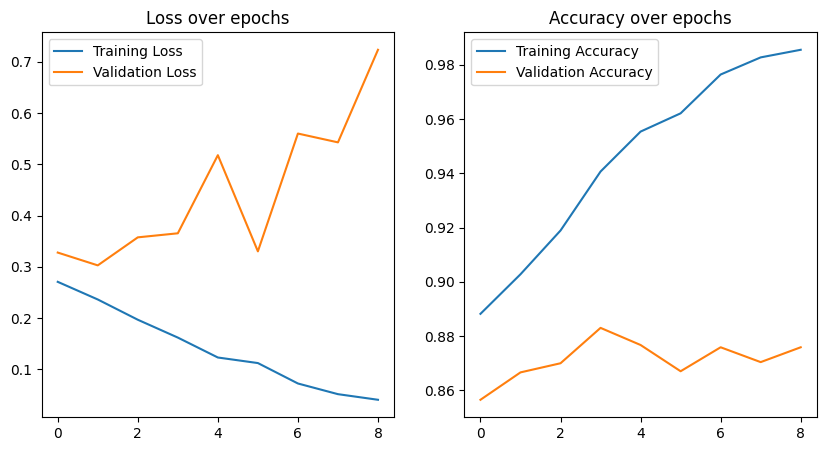

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()